In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import astropy.units as u
from astropy.coordinates import SkyCoord, Galactocentric
from gala import potential as gp, dynamics as gd
plt.style.use("style.mpl")

In [2]:
df = pd.read_csv("k2_gaia_andrae_merged.csv")
print(f"Total rows: {len(df)}")

# Use Gaia RA/Dec where available, fall back to K2
df["ra_use"] = df["ra_gaia"].fillna(df["ra_k2"])
df["dec_use"] = df["dec_gaia"].fillna(df["dec_k2"])

# Filter to rows with complete astrometry for the Toomre diagram
mask = (
    df["ra_use"].notna()
    & df["dec_use"].notna()
    & df["parallax"].notna()
    & (df["parallax"] > 0)
    & df["pmra"].notna()
    & df["pmdec"].notna()
    & df["radial_velocity"].notna()
)
kin = df[mask].copy()
print(f"Stars with full astrometry (Toomre-ready): {len(kin)}")

Total rows: 1806
Stars with full astrometry (Toomre-ready): 705


## Compute Galactocentric cylindrical velocities

In [3]:
kin["distance_pc"] = 1000.0 / kin["parallax"]

c_icrs = SkyCoord(
    ra=kin["ra_use"].values * u.deg,
    dec=kin["dec_use"].values * u.deg,
    distance=kin["distance_pc"].values * u.pc,
    pm_ra_cosdec=kin["pmra"].values * u.mas / u.yr,
    pm_dec=kin["pmdec"].values * u.mas / u.yr,
    radial_velocity=kin["radial_velocity"].values * u.km / u.s,
    frame="icrs",
)

galcen = c_icrs.transform_to(Galactocentric())

# Cylindrical velocities from Cartesian (following Chandra et al. convention)
x, y, z = galcen.x, galcen.y, galcen.z
vx, vy, vz = galcen.v_x, galcen.v_y, galcen.v_z

R = np.hypot(x, y)
vphi = (x * vy - y * vx) / R  # positive = prograde
vr = (x * vx + y * vy) / R

kin["vphi"] = vphi.to(u.km / u.s).value
kin["vr"] = vr.to(u.km / u.s).value
kin["vz"] = vz.to(u.km / u.s).value
kin["vperp"] = np.sqrt(kin["vr"] ** 2 + kin["vz"] ** 2)
kin["R_kpc"] = R.to(u.kpc).value

# Planet names per host star
planet_names = (
    df.groupby("source_id")["pl_name"]
    .apply(lambda x: ", ".join(sorted(x.unique())))
    .reset_index()
)
planet_names.columns = ["source_id", "planet_names"]
kin = kin.merge(planet_names, on="source_id", how="left")


## Classify populations by Toomre velocity relative to the Sun

In [4]:
sun_x, sun_y = 245.6, 15.1

kin_plot = kin.copy()
kin_plot["planet_names"] = kin_plot["planet_names"].fillna("")
kin_plot["x"] = -kin_plot["vphi"]
kin_plot["y"] = kin_plot["vperp"]
kin_plot["r_from_sun"] = np.sqrt(
    (kin_plot["x"] - sun_x) ** 2 + (kin_plot["y"] - sun_y) ** 2
)

kin_plot["pop"] = "thin_disk"
kin_plot.loc[
    (kin_plot["r_from_sun"] > 150.0) & (kin_plot["r_from_sun"] <= 250.0), "pop"
] = "thick_disk"
kin_plot.loc[kin_plot["r_from_sun"] > 250.0, "pop"] = "halo"

thin = kin_plot[kin_plot["pop"] == "thin_disk"]
thick = kin_plot[kin_plot["pop"] == "thick_disk"]
halo = kin_plot[kin_plot["pop"] == "halo"]

# Save full kinematic table
kin_plot.to_csv("k2_hosts_gaia_toomre_table.csv", index=False)

# Print summary
print(f"\nPopulation breakdown:")
print(f"  Thin disk:  {len(thin)}")
print(f"  Thick disk: {len(thick)}")
print(f"  Halo:       {len(halo)}")


Population breakdown:
  Thin disk:  693
  Thick disk: 6
  Halo:       6


In [5]:
print(f"\nHalo candidates:")
print(f"  {'Name':35s} {'vphi':>8s} {'vperp':>8s} {'[M/H]_XP':>10s} {'[M/H]_GSP':>10s}")
for _, row in halo.sort_values("mh_xgboost").iterrows():
    label = row["planet_names"] if row["planet_names"] else str(int(row["source_id"]))
    print(
        f"  {label:35s} {row['vphi']:8.1f} {row['vperp']:8.1f} "
        f"{row.get('mh_xgboost', np.nan):10.3f} {row.get('mh_gspphot', np.nan):10.3f}"
    )

print(f"\nThick disk candidates:")
print(f"  {'Name':35s} {'vphi':>8s} {'vperp':>8s} {'[M/H]_XP':>10s}")
for _, row in thick.sort_values("mh_xgboost").iterrows():
    label = row["planet_names"] if row["planet_names"] else str(int(row["source_id"]))
    print(
        f"  {label:35s} {row['vphi']:8.1f} {row['vperp']:8.1f} "
        f"{row.get('mh_xgboost', np.nan):10.3f}"
    )


Halo candidates:
  Name                                    vphi    vperp   [M/H]_XP  [M/H]_GSP
  EPIC 215381481.01                      -95.8    272.9     -1.706      0.019
  EPIC 211106187.01                      134.6    292.6     -1.534        nan
  EPIC 211308899.01                       11.5    172.2     -1.174     -0.340
  EPIC 211407755.01                       39.4    254.0     -0.879     -0.638
  EPIC 215125108.01                      139.1     29.9     -0.385        nan
  EPIC 211064647.01                       23.5    100.6     -0.331     -0.981

Thick disk candidates:
  Name                                    vphi    vperp   [M/H]_XP
  K2-180 b                              -197.0    157.2     -0.670
  EPIC 212068493.01                      -89.8     26.3     -0.494
  EPIC 202071401.01                      -93.2     76.9     -0.410
  EPIC 211319779.01                     -121.6    104.1     -0.406
  EPIC 249561595.01                     -116.0    100.1     -0.342
  EPIC 212

In [14]:
kin_plot.columns

Index(['pl_name', 'hostname', 'epic_hostname', 'gaia_dr3_id', 'default_flag',
       'disposition', 'disp_refname', 'sy_snum', 'sy_pnum', 'discoverymethod',
       ...
       'vphi', 'vr', 'vz', 'vperp', 'R_kpc', 'planet_names', 'x', 'y',
       'r_from_sun', 'pop'],
      dtype='object', length=136)

In [ ]:
kin_plot[kin_plot["planet_names"] == "K2-180 b"]

,pl_name,hostname,epic_hostname,gaia_dr3_id,default_flag,disposition,disp_refname,sy_snum,sy_pnum,discoverymethod,...,vphi,vr,vz,vperp,R_kpc,planet_names,x,y,r_from_sun,pop
534,K2-180 b,K2-180,EPIC 211319617,Gaia DR3 600750922666388992,1,CONFIRMED,Mayo et al. 2018,1.0,1.0,Transit,...,-196.95886,-156.206819,17.60645,157.19592,8.274075,K2-180 b,196.95886,157.19592,150.190583,thick_disk


## Plot Toomre


Saved toomre_k2.pdf and toomre_k2.png


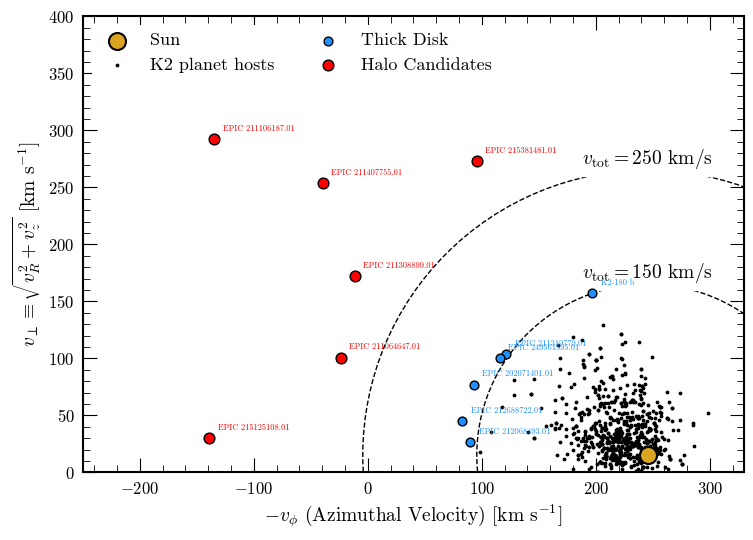

In [7]:
fig, ax = plt.subplots(figsize=(8, 7))

# Sun marker
ax.scatter(
    sun_x, sun_y,
    marker="o", color="goldenrod", label="Sun",
    s=150, edgecolor="k", lw=1.5, zorder=10,
)

# Thin disk: black, small
ax.scatter(
    thin["x"], thin["y"],
    s=3, color="k", label="K2 planet hosts",
    rasterized=True, alpha=1,
)

# Thick disk: blue, medium
ax.scatter(
    thick["x"], thick["y"],
    s=40, color="dodgerblue", edgecolor="k",
    label="Thick Disk", zorder=4,
)
for _, row in thick.iterrows():
    label = row["planet_names"] if row["planet_names"] else str(int(row["source_id"]))
    ax.annotate(
        label, (row["x"], row["y"]),
        textcoords="offset points", xytext=(6, 6),
        fontsize=6, color="dodgerblue", zorder=6,
    )

# Halo candidates: red, larger
ax.scatter(
    halo["x"], halo["y"],
    s=60, color="red", edgecolor="k",
    label="Halo Candidates", zorder=5,
)
for _, row in halo.iterrows():
    label = row["planet_names"] if row["planet_names"] else str(int(row["source_id"]))
    ax.annotate(
        label, (row["x"], row["y"]),
        textcoords="offset points", xytext=(6, 6),
        fontsize=6, color="red", zorder=6,
    )

# Legend
lfs = 13
legend = ax.legend(loc="upper left", markerfirst=True, framealpha=1, fontsize=lfs, ncol=2)
legend.get_frame().set_edgecolor("none")

# Toomre circles at 150 and 250 km/s
vtots = [150, 250]
for vtot in vtots:
    circ = mpatches.Circle(
        (sun_x, sun_y), vtot,
        color="k", ls="--", lw=1, fill=False, zorder=0,
    )
    ax.add_patch(circ)
    ax.text(
        sun_x, vtot + sun_y + 10.0,
        rf"$v_{{\mathrm{{tot}}}} = {vtot}$ km/s",
        ha="center", va="center", fontsize=14,
        bbox=dict(facecolor="w", edgecolor="w"),
    )

ax.set_xlim(-250, 330)
ax.set_ylim(0, 400)
ax.set_aspect("equal")
ax.set_xlabel(r"$-v_{\phi}$ (Azimuthal Velocity) [km s$^{-1}$]", fontsize=14)
ax.set_ylabel(
    r"$v_\perp \equiv \sqrt{v_R^2 + v_z^2}$ [km s$^{-1}$]", fontsize=14
)
ax.tick_params(labelsize=12)

plt.tight_layout()
plt.savefig("toomre_k2.pdf", dpi=150)
plt.savefig("toomre_k2.png", dpi=200)
print("\nSaved toomre_k2.pdf and toomre_k2.png")
plt.show()

## Orbits

/Users/jea/miniforge3/envs/tess/lib/python3.11/site-packages/gala/potential/potential/builtin/special.py:193: GalaFutureWarning: In a future version of Gala, the current MilkyWayPotential and MilkyWayPotential2022 classes will be combined into a single class, MilkyWayPotential, with an optional 'version' argument to select between the models. To use the old (version 1) MilkyWayPotential, specify version="v1" when creating an instance. To use the newer (version 2 = current MilkyWayPotential2022), specify version="v2".
  warnings.warn(


  EPIC 211064647.01                    e=0.83  peri=0.9  apo=9.5 kpc  vphi=23 km/s  [M/H]_XP=-0.33
  EPIC 211106187.01                    e=0.78  peri=4.0  apo=32.2 kpc  vphi=135 km/s  [M/H]_XP=-1.53
  EPIC 211308899.01                    e=0.90  peri=0.8  apo=15.0 kpc  vphi=11 km/s  [M/H]_XP=-1.17
  EPIC 211407755.01                    e=0.92  peri=0.7  apo=15.9 kpc  vphi=39 km/s  [M/H]_XP=-0.88
  EPIC 215125108.01                    e=0.22  peri=1.8  apo=2.9 kpc  vphi=139 km/s  [M/H]_XP=-0.39
  EPIC 215381481.01                    e=0.29  peri=3.1  apo=5.5 kpc  vphi=-96 km/s  [M/H]_XP=-1.71

Saved halo_orbits.pdf and halo_orbits.png


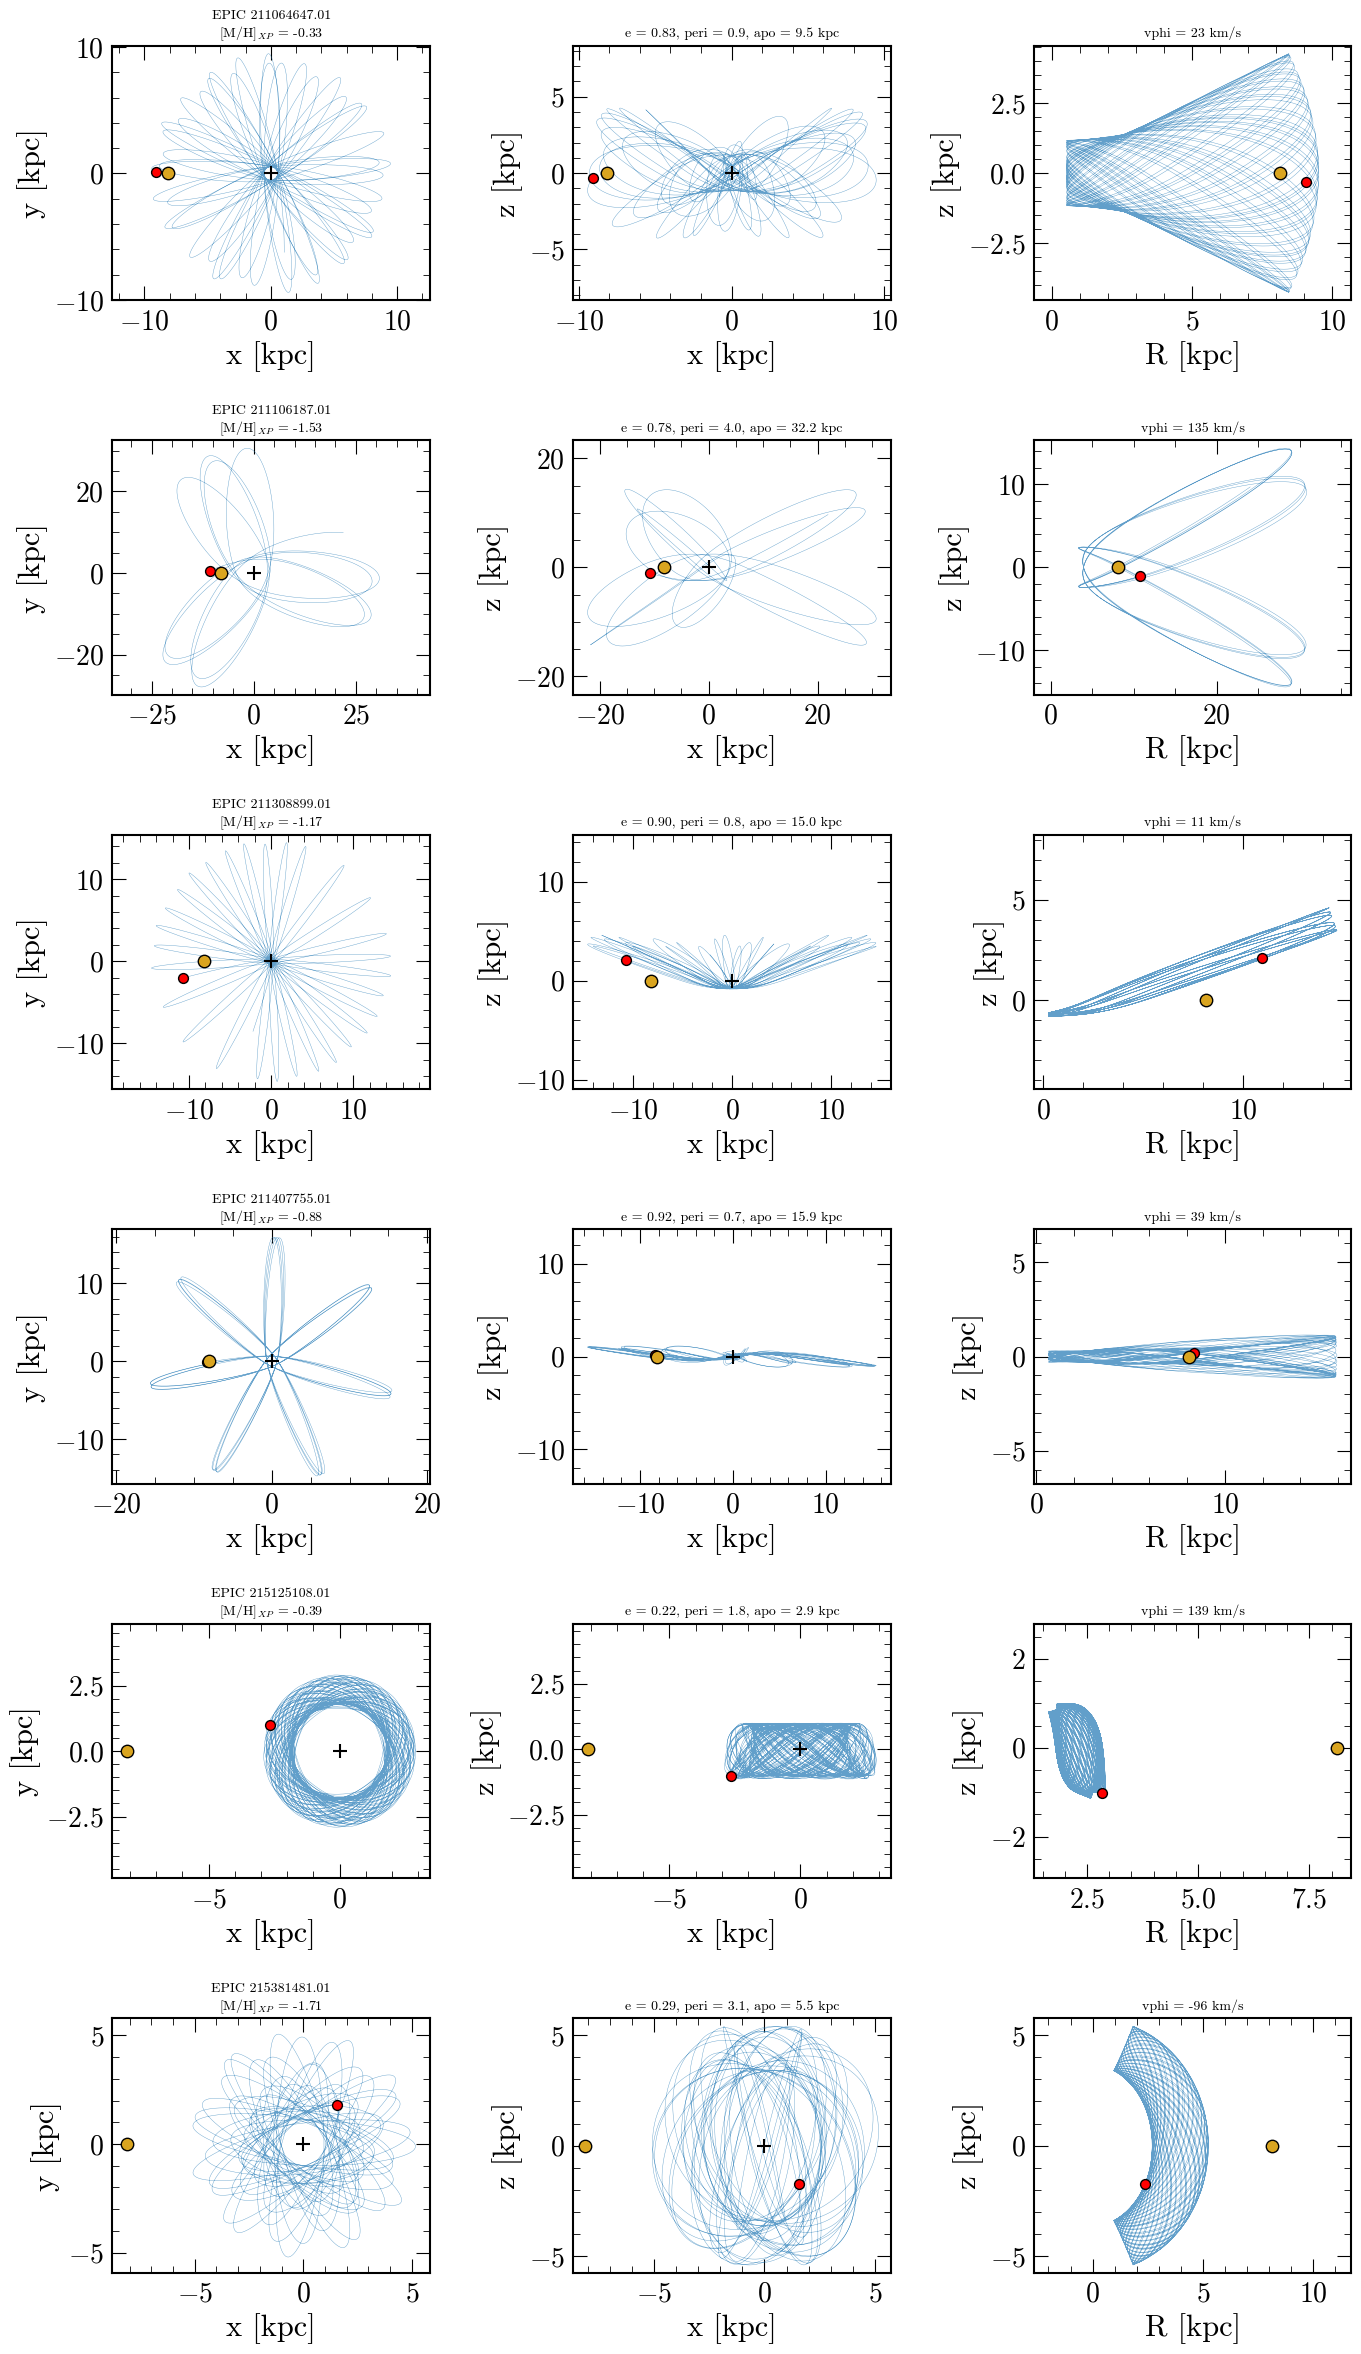

In [9]:
potential = gp.MilkyWayPotential()
galcen_frame = Galactocentric()

# =============================================================================
# 3. Integrate orbits and plot
# =============================================================================

fig, axes = plt.subplots(6, 3, figsize=(14, 24))

for i, (_, row) in enumerate(halo.iterrows()):
    name = row["planet_names"] if pd.notna(row["planet_names"]) else str(int(row["source_id"]))
    mh = row["mh_xgboost"] if pd.notna(row.get("mh_xgboost")) else np.nan

    # Build ICRS coordinate from Gaia astrometry
    icrs = SkyCoord(
        ra=row["ra_use"] * u.deg,
        dec=row["dec_use"] * u.deg,
        distance=(1000.0 / row["parallax"]) * u.pc,
        pm_ra_cosdec=row["pmra"] * u.mas / u.yr,
        pm_dec=row["pmdec"] * u.mas / u.yr,
        radial_velocity=row["radial_velocity"] * u.km / u.s,
        frame="icrs",
    )

    # Transform to Galactocentric and integrate orbit
    galcen = icrs.transform_to(galcen_frame)
    w0 = gd.PhaseSpacePosition(galcen.data)
    orbit = potential.integrate_orbit(w0, dt=-0.1 * u.Myr, n_steps=50000)

    # Orbital parameters
    peri = orbit.pericenter().to(u.kpc).value
    apo = orbit.apocenter().to(u.kpc).value
    ecc = orbit.eccentricity()

    # Extract positions along orbit
    ox = orbit.x.to(u.kpc).value
    oy = orbit.y.to(u.kpc).value
    oz = orbit.z.to(u.kpc).value
    oR = np.sqrt(ox**2 + oy**2)

    # Current position of the star
    cx = galcen.x.to(u.kpc).value
    cy = galcen.y.to(u.kpc).value
    cz = galcen.z.to(u.kpc).value
    cR = np.sqrt(cx**2 + cy**2)

    # ── Panel 1: Face-on (x-y) ──
    ax = axes[i, 0]
    ax.plot(ox, oy, color="C0", lw=0.3, alpha=0.7, rasterized=True)
    ax.scatter(cx, cy, color="red", s=50, zorder=10, edgecolor="k")
    ax.scatter(0, 0, color="k", marker="+", s=100, zorder=10)  # Galactic center
    ax.scatter(-8.122, 0, color="goldenrod", s=80, edgecolor="k", zorder=10)  # Sun
    ax.set_xlabel("x [kpc]")
    ax.set_ylabel("y [kpc]")
    ax.set_aspect("equal", adjustable="datalim")
    ax.set_title(f"{name}\n[M/H]$_{{XP}}$ = {mh:.2f}", fontsize=10)

    # ── Panel 2: Edge-on (x-z) ──
    ax = axes[i, 1]
    ax.plot(ox, oz, color="C0", lw=0.3, alpha=0.7, rasterized=True)
    ax.scatter(cx, cz, color="red", s=50, zorder=10, edgecolor="k")
    ax.scatter(0, 0, color="k", marker="+", s=100, zorder=10)
    ax.scatter(-8.122, 0, color="goldenrod", s=80, edgecolor="k", zorder=10)
    ax.set_xlabel("x [kpc]")
    ax.set_ylabel("z [kpc]")
    ax.set_aspect("equal", adjustable="datalim")
    ax.set_title(f"e = {ecc:.2f}, peri = {peri:.1f}, apo = {apo:.1f} kpc", fontsize=10)

    # ── Panel 3: Meridional (R-z) ──
    ax = axes[i, 2]
    ax.plot(oR, oz, color="C0", lw=0.3, alpha=0.7, rasterized=True)
    ax.scatter(cR, cz, color="red", s=50, zorder=10, edgecolor="k")
    ax.scatter(8.122, 0, color="goldenrod", s=80, edgecolor="k", zorder=10)
    ax.set_xlabel("R [kpc]")
    ax.set_ylabel("z [kpc]")
    ax.set_aspect("equal", adjustable="datalim")
    ax.set_title(f"vphi = {row['vphi']:.0f} km/s", fontsize=10)

    print(
        f"  {name:35s}  e={ecc:.2f}  peri={peri:.1f}  apo={apo:.1f} kpc  "
        f"vphi={row['vphi']:.0f} km/s  [M/H]_XP={mh:.2f}"
    )

plt.tight_layout()
plt.savefig("halo_orbits.pdf", dpi=150)
plt.savefig("halo_orbits.png", dpi=180)
print("\nSaved halo_orbits.pdf and halo_orbits.png")
plt.show()


Saved mh_vphi_k2.pdf/png


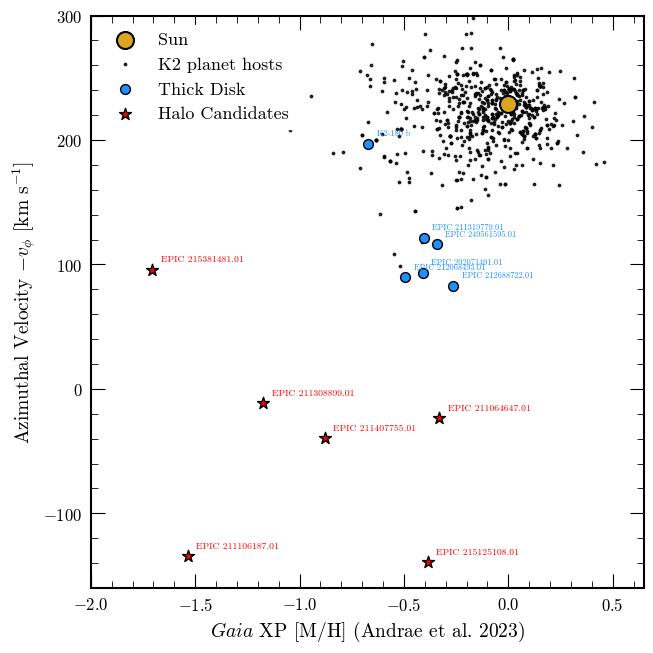

In [10]:
fig, ax = plt.subplots(figsize=(7, 7))

# Sun
ax.scatter(
    0.0, 229, marker="o", color="goldenrod", s=150,
    edgecolor="k", lw=1.5, zorder=10, label="Sun",
)

# K2 hosts (thin disk)
ax.scatter(
    thin["mh_xgboost"], -thin["vphi"], color="k", s=3,
    label="K2 planet hosts", rasterized=True, alpha=0.8,
)

# Thick disk
ax.scatter(
    thick["mh_xgboost"], -thick["vphi"], color="dodgerblue", s=50,
    edgecolor="k", label="Thick Disk", zorder=4,
)
for _, row in thick.iterrows():
    label = row["planet_names"] if pd.notna(row["planet_names"]) and row["planet_names"] else str(int(row["source_id"]))
    ax.annotate(
        label, (row["mh_xgboost"], -row["vphi"]),
        textcoords="offset points", xytext=(6, 6),
        fontsize=6, color="dodgerblue", zorder=6,
    )

# Halo candidates
ax.scatter(
    halo["mh_xgboost"], -halo["vphi"], color="red", s=80,
    edgecolor="k", label="Halo Candidates", zorder=5, marker="*", lw=1,
)
for _, row in halo.iterrows():
    label = row["planet_names"] if pd.notna(row["planet_names"]) and row["planet_names"] else str(int(row["source_id"]))
    ax.annotate(
        label, (row["mh_xgboost"], -row["vphi"]),
        textcoords="offset points", xytext=(6, 6),
        fontsize=7, color="red", zorder=6,
    )

ax.set_xlim(-2.0, 0.65)
ax.set_ylim(-160, 300)

ax.set_xlabel(r"$Gaia$ XP [M/H] (Andrae et al. 2023)", fontsize=14)
ax.set_ylabel(r"Azimuthal Velocity $-v_{\phi}$ [km s$^{-1}$]", fontsize=14)
ax.tick_params(labelsize=12)

legend = ax.legend(loc="upper left", framealpha=1, edgecolor="w", fontsize=13)

plt.tight_layout()
plt.savefig("mh_vphi_k2.pdf", dpi=150)
plt.savefig("mh_vphi_k2.png", dpi=200)
print("Saved mh_vphi_k2.pdf/png")
plt.show()

/Users/jea/miniforge3/envs/tess/lib/python3.11/site-packages/gala/potential/potential/builtin/special.py:193: GalaFutureWarning: In a future version of Gala, the current MilkyWayPotential and MilkyWayPotential2022 classes will be combined into a single class, MilkyWayPotential, with an optional 'version' argument to select between the models. To use the old (version 1) MilkyWayPotential, specify version="v1" when creating an instance. To use the newer (version 2 = current MilkyWayPotential2022), specify version="v2".
  warnings.warn(


  EPIC 202071401.01                    e=0.62  peri=2.0  apo=8.6 kpc  vphi=-93 km/s  [M/H]_XP=-0.41
  EPIC 211319779.01                    e=0.53  peri=2.8  apo=9.2 kpc  vphi=-122 km/s  [M/H]_XP=-0.41
  EPIC 212068493.01                    e=0.62  peri=2.0  apo=8.6 kpc  vphi=-90 km/s  [M/H]_XP=-0.49
  EPIC 212688722.01                    e=0.61  peri=1.8  apo=7.3 kpc  vphi=-83 km/s  [M/H]_XP=-0.26
  EPIC 249561595.01                    e=0.44  peri=2.8  apo=7.2 kpc  vphi=-116 km/s  [M/H]_XP=-0.34
  K2-180 b                             e=0.49  peri=4.6  apo=13.2 kpc  vphi=-197 km/s  [M/H]_XP=-0.67

Saved thick_disk_orbits.pdf and thick_disk_orbits.png


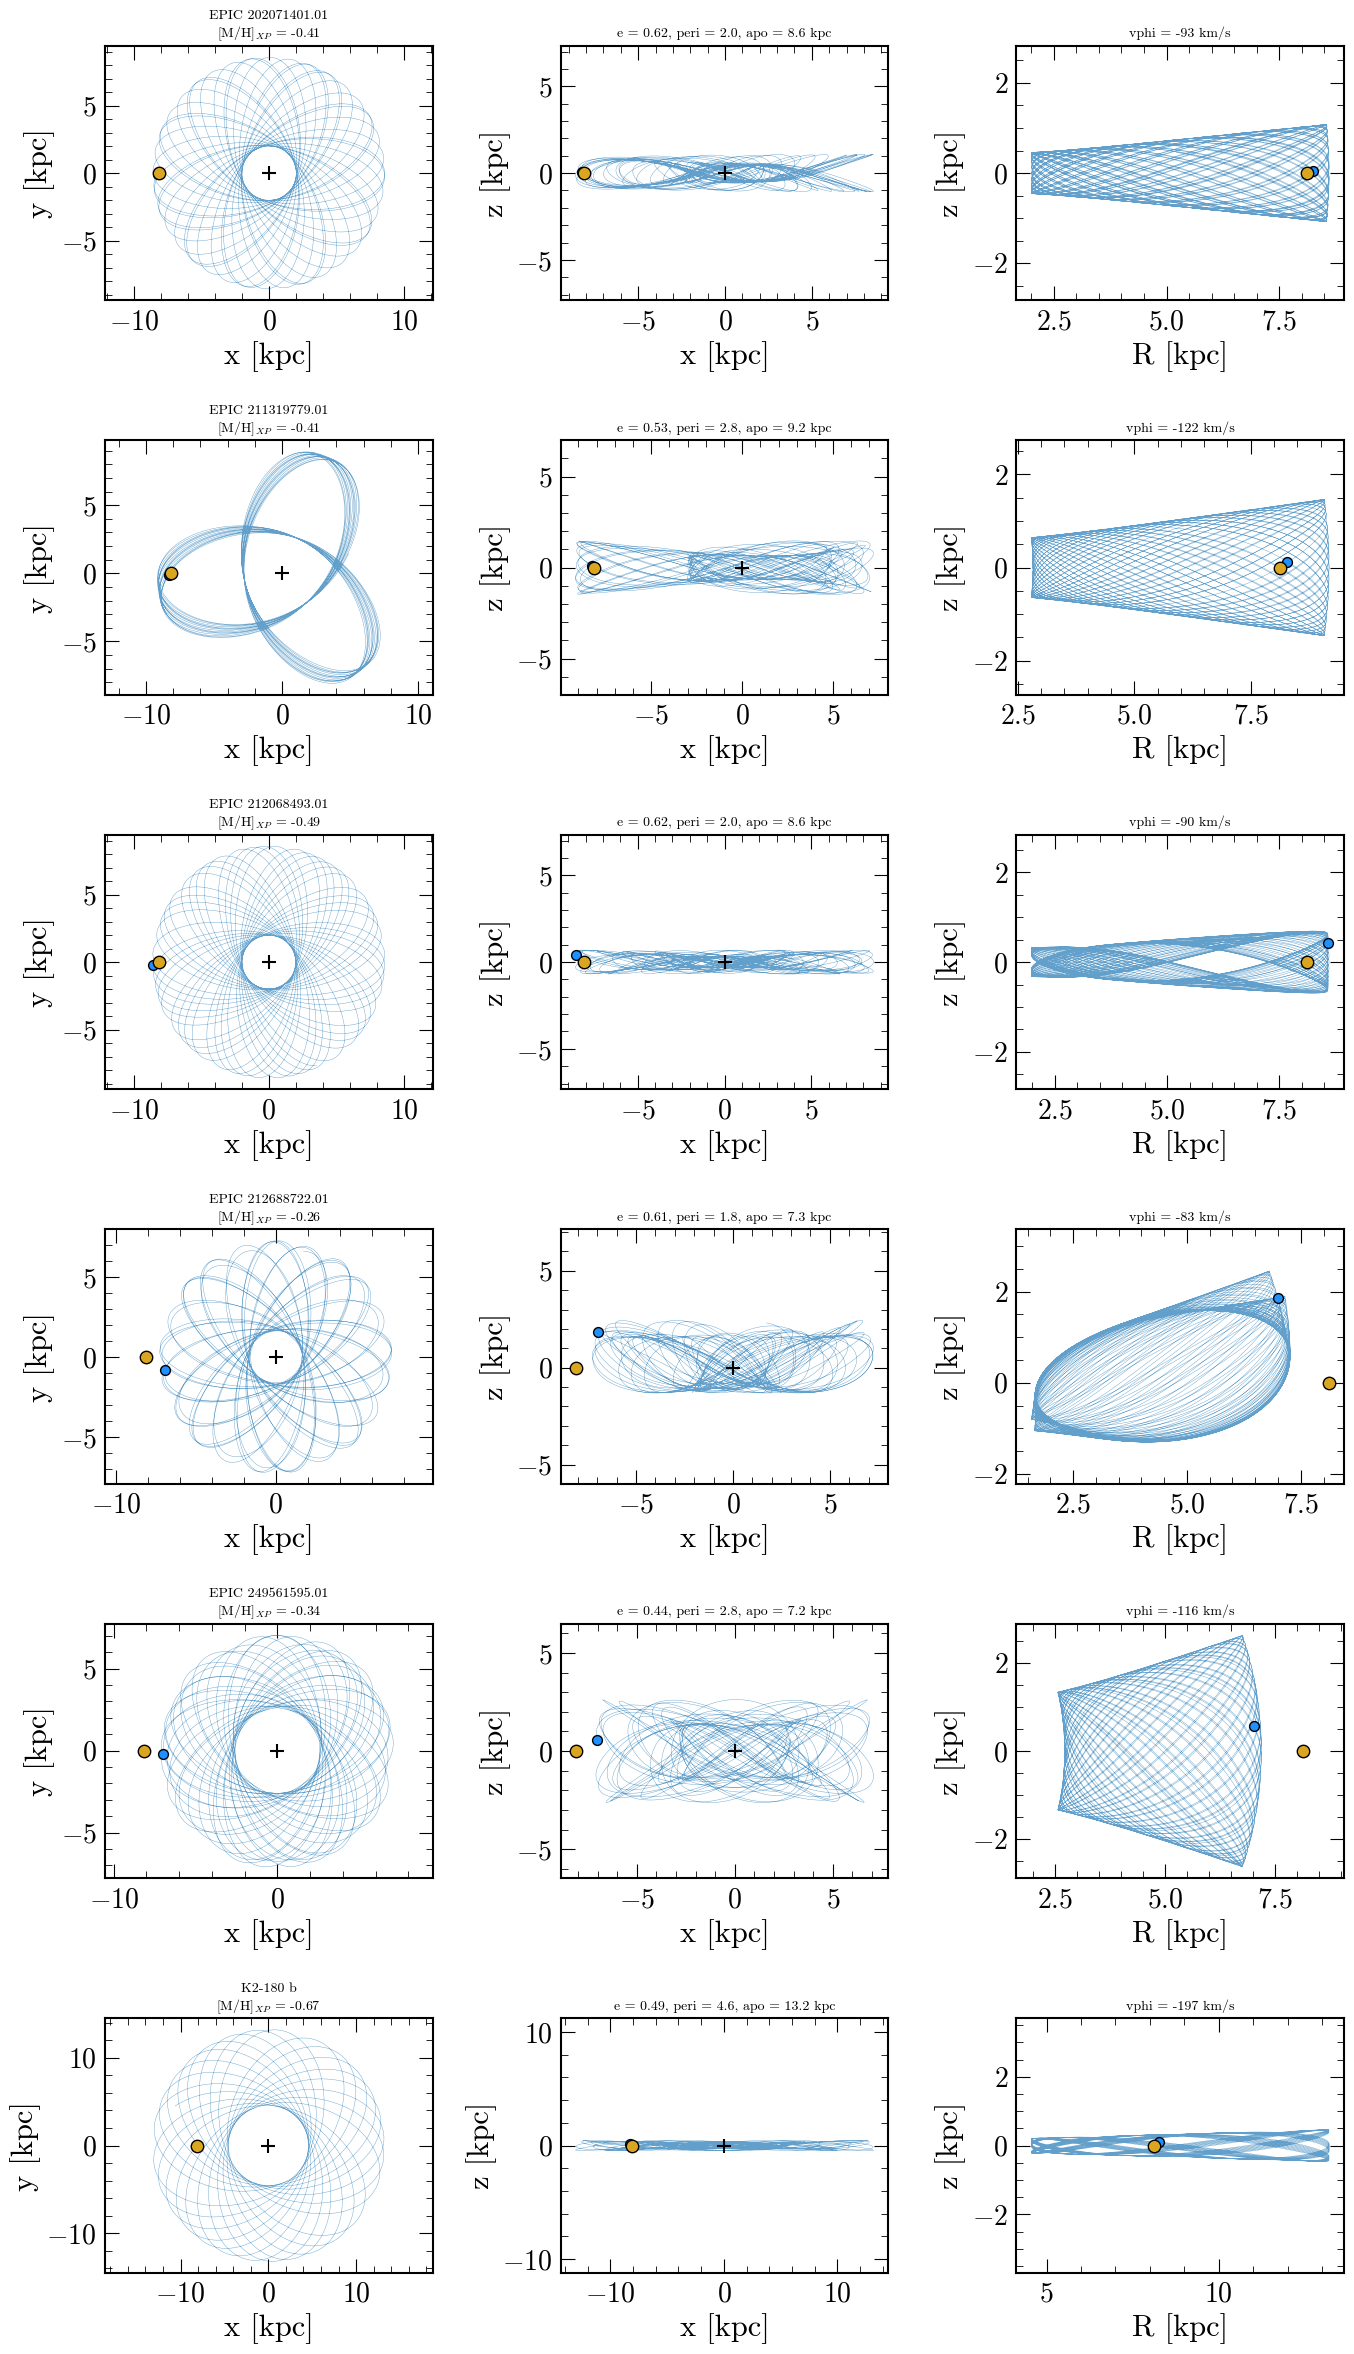

In [15]:
## Thick disk orbits (same layout as halo orbits)

potential = gp.MilkyWayPotential()
galcen_frame = Galactocentric()

n_thick = len(thick)
fig, axes = plt.subplots(n_thick, 3, figsize=(14, 4 * n_thick))

for i, (_, row) in enumerate(thick.iterrows()):
    name = row["planet_names"] if pd.notna(row["planet_names"]) and row["planet_names"] else str(int(row["source_id"]))
    mh = row["mh_xgboost"] if pd.notna(row.get("mh_xgboost")) else np.nan

    # Build ICRS coordinate from Gaia astrometry
    icrs = SkyCoord(
        ra=row["ra_use"] * u.deg,
        dec=row["dec_use"] * u.deg,
        distance=(1000.0 / row["parallax"]) * u.pc,
        pm_ra_cosdec=row["pmra"] * u.mas / u.yr,
        pm_dec=row["pmdec"] * u.mas / u.yr,
        radial_velocity=row["radial_velocity"] * u.km / u.s,
        frame="icrs",
    )

    # Transform to Galactocentric and integrate orbit
    galcen = icrs.transform_to(galcen_frame)
    w0 = gd.PhaseSpacePosition(galcen.data)
    orbit = potential.integrate_orbit(w0, dt=-0.1 * u.Myr, n_steps=50000)

    # Orbital parameters
    peri = orbit.pericenter().to(u.kpc).value
    apo = orbit.apocenter().to(u.kpc).value
    ecc = orbit.eccentricity()

    # Extract positions along orbit
    ox = orbit.x.to(u.kpc).value
    oy = orbit.y.to(u.kpc).value
    oz = orbit.z.to(u.kpc).value
    oR = np.sqrt(ox**2 + oy**2)

    # Current position of the star
    cx = galcen.x.to(u.kpc).value
    cy = galcen.y.to(u.kpc).value
    cz = galcen.z.to(u.kpc).value
    cR = np.sqrt(cx**2 + cy**2)

    # ── Panel 1: Face-on (x-y) ──
    ax = axes[i, 0]
    ax.plot(ox, oy, color="C0", lw=0.3, alpha=0.7, rasterized=True)
    ax.scatter(cx, cy, color="dodgerblue", s=50, zorder=10, edgecolor="k")
    ax.scatter(0, 0, color="k", marker="+", s=100, zorder=10)  # Galactic center
    ax.scatter(-8.122, 0, color="goldenrod", s=80, edgecolor="k", zorder=10)  # Sun
    ax.set_xlabel("x [kpc]")
    ax.set_ylabel("y [kpc]")
    ax.set_aspect("equal", adjustable="datalim")
    ax.set_title(f"{name}\n[M/H]$_{{XP}}$ = {mh:.2f}", fontsize=10)

    # ── Panel 2: Edge-on (x-z) ──
    ax = axes[i, 1]
    ax.plot(ox, oz, color="C0", lw=0.3, alpha=0.7, rasterized=True)
    ax.scatter(cx, cz, color="dodgerblue", s=50, zorder=10, edgecolor="k")
    ax.scatter(0, 0, color="k", marker="+", s=100, zorder=10)
    ax.scatter(-8.122, 0, color="goldenrod", s=80, edgecolor="k", zorder=10)
    ax.set_xlabel("x [kpc]")
    ax.set_ylabel("z [kpc]")
    ax.set_aspect("equal", adjustable="datalim")
    ax.set_title(f"e = {ecc:.2f}, peri = {peri:.1f}, apo = {apo:.1f} kpc", fontsize=10)

    # ── Panel 3: Meridional (R-z) ──
    ax = axes[i, 2]
    ax.plot(oR, oz, color="C0", lw=0.3, alpha=0.7, rasterized=True)
    ax.scatter(cR, cz, color="dodgerblue", s=50, zorder=10, edgecolor="k")
    ax.scatter(8.122, 0, color="goldenrod", s=80, edgecolor="k", zorder=10)
    ax.set_xlabel("R [kpc]")
    ax.set_ylabel("z [kpc]")
    ax.set_aspect("equal", adjustable="datalim")
    ax.set_title(f"vphi = {row['vphi']:.0f} km/s", fontsize=10)

    print(
        f"  {name:35s}  e={ecc:.2f}  peri={peri:.1f}  apo={apo:.1f} kpc  "
        f"vphi={row['vphi']:.0f} km/s  [M/H]_XP={mh:.2f}"
    )

plt.tight_layout()
plt.savefig("thick_disk_orbits.pdf", dpi=150)
plt.savefig("thick_disk_orbits.png", dpi=180)
print("\nSaved thick_disk_orbits.pdf and thick_disk_orbits.png")
plt.show()
